In [1]:
#Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

sns.set()


#Modeling 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import pickle


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter




import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Nulls, N/A, other
- id - all unique values, no nulls, convert to object dtype **Done**
- gender - drop value: "Other" (one count) **Done**
- age - no nulls, consider additional age ranges column instead (low-age has decimal values) **Done**
- hypertension - no nulls, convert to object dtype **Done**
- heart_disease - no nulls, convert to object dtype **Done**
- ever_married - no nulls, Yes/No, encode to new column with 0/1 or True/False (handled with modeling_df)
- work_type - no nulls, uses strings to describe, use one-hot encoding into each new column (handled w modeling_df)
- Residence_type - one-hot encode into is_Urban (handled w modeling_df)
- avg_glucose_level - no nulls, continuous values **Done**
- bmi - hangle nulls by imputing mean by age category and also gender, normal distribution **Done**
    * use pd.cut to create bins: 0-4, 5-9, 10-14, 15-19, ...
    * use existing gender column as well
- smoking_status - no nulls, one-hot encode (handled w modeling_df)
- stroke - no nulls, convert to string **Done**

In [4]:
df = df.drop(3116).reset_index().drop(columns='index') # index 3116 has gender 'Other', only one value

In [5]:
df['id'] = df.id.astype('object')
df['hypertension'] = df.hypertension.astype('object')
df['heart_disease'] = df.heart_disease.astype('object')
df['stroke'] = df.stroke.astype('object')

In [ ]:
# five_year_cutpoints = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
# df['age_range'] = pd.cut(x=df.age, bins=five_year_cutpoints).astype('string')

In [ ]:
# df['age_range'] = df['age_range'].str[1:-1]\
#                   .str.replace(', ', '-')\
#                   .astype('object')

In [ ]:
df.head(3)

In [ ]:
df.info()

In [ ]:
# grouped = df.groupby(['age_range', 'gender']).bmi.mean()

In [ ]:
# grouped['65-70']['Male']

In [ ]:
# #literally magic
# df.loc[df.bmi.isna(), 'bmi'] = df[df.bmi.isna()]\
# #                                          .apply(lambda x: grouped[x.age_range][x.gender], axis=1)

In [6]:
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   object 
 1   gender             5109 non-null   object 
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   object 
 4   heart_disease      5109 non-null   object 
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                4908 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   object 
dtypes: float64(3), object(9)
memory usage: 479.1+ KB


In [ ]:
# df.to_csv('.csv')

In [ ]:
# modeling_df = pd.get_dummies(df, drop_first=True)

In [ ]:
df

## Impute the Missing Values in the BMI column


In [7]:
#imputing the missing values with the mean
df = df.fillna(np.mean(df['bmi']))
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.89456,never smoked,0
5105,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00000,never smoked,0
5106,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60000,never smoked,0
5107,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.60000,formerly smoked,0


In [8]:
#checking on those nulls
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Data Visualization: Features/Target

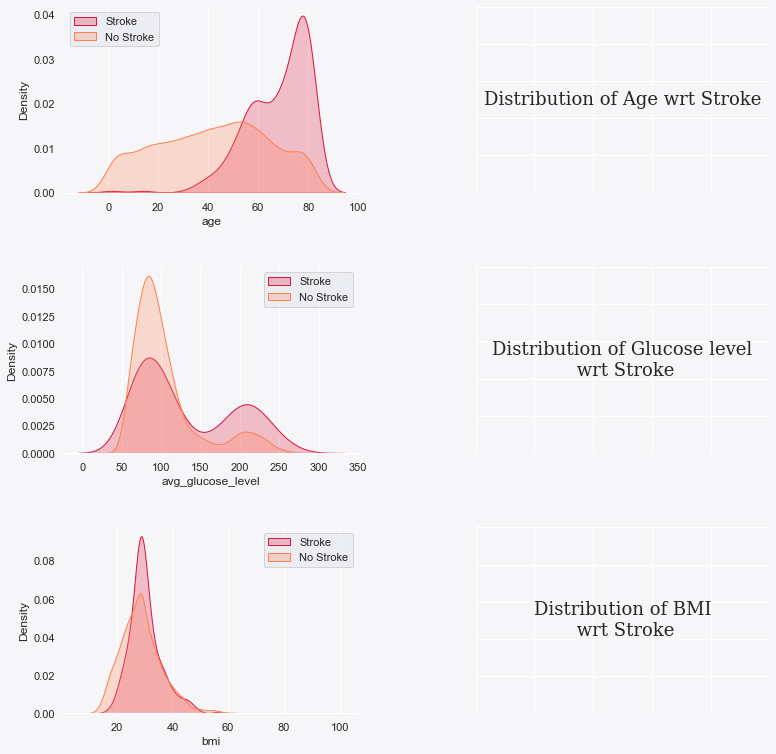

In [9]:
# Analysis with Stroke
fig = plt.figure(figsize=(20,13))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.4, hspace=0.4)
# adding figures
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
axes=[ax0,ax1,ax2,ax3,ax4,ax5]
background_color = '#f6f5f7'
for i in axes:
    i.set_facecolor(background_color)
fig.patch.set_facecolor(background_color) 
#https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/
sns.kdeplot(ax=ax0,x=df.loc[df['stroke']==1]['age'],color='crimson',label='Stroke',shade=True)
sns.kdeplot(ax=ax0,x=df.loc[df['stroke']==0]['age'],color='coral',label='No Stroke',shade=True)
ax0.legend(loc = 'upper left')
ax0.grid(linestyle='--', axis='y')

ax1.text(0.5,0.5,'Distribution of Age wrt Stroke',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')

sns.kdeplot(ax=ax2,x=df.loc[df['stroke']==1]['avg_glucose_level'],color='crimson',label='Stroke',shade=True)
sns.kdeplot(ax=ax2,x=df.loc[df['stroke']==0]['avg_glucose_level'],color='coral',label='No Stroke',shade=True)
ax2.legend(loc = 'upper right')
ax2.grid(linestyle='--', axis='y')

ax3.text(0.5,0.5,'Distribution of Glucose level\n wrt Stroke',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')


sns.kdeplot(ax=ax4,x=df.loc[df['stroke']==1]['bmi'],color='crimson',label='Stroke',shade=True)
sns.kdeplot(ax=ax4,x=df.loc[df['stroke']==0]['bmi'],color='coral',label='No Stroke',shade=True)
ax4.legend(loc = 'upper right')
ax4.grid(linestyle='--', axis='y')

ax5.text(0.5,0.5,'Distribution of BMI\n wrt Stroke',horizontalalignment = 'center',verticalalignment = 'center',fontsize = 18,fontfamily='serif')
# removing labels

axes1=[ax1,ax3,ax5]
for i in axes1:
    i.spines["bottom"].set_visible(False)
    i.spines["left"].set_visible(False)
    i.set_xlabel("")
    i.set_ylabel("")
    i.set_xticklabels([])
    i.set_yticklabels([])
    i.tick_params(left=False, bottom=False)
# removing spines of figures
for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    ax3.spines[i].set_visible(False)
    ax4.spines[i].set_visible(False)
    ax5.spines[i].set_visible(False)

## New Insightful Features:
- Obesity Feature:The BMI index works as a range in combination with height and weight. Since we don't have that info, I am going to average the range and apply the BMI value.

In [12]:
# 0 - Underweight; 1 - Healthy; 2 - Overweight; 3 - Obese
df['obesity'] = 0
df['obesity'].loc[df['bmi'] > 18 ] = 1
df['obesity'].loc[df['bmi'] > 25 ] = 2
df['obesity'].loc[df['bmi'] > 30 ] = 3

# 0 - Low; 1 - Normal; 2 - Diabetic
df['diabetic'] = 0
df['diabetic'].loc[df['avg_glucose_level'] > 60 ] = 1
df['diabetic'].loc[df['avg_glucose_level'] > 125 ] = 2

df['married'] = 0
df['married'].loc[df['ever_married'] ==  'Yes' ] = 1

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['smoking_status'] = df['smoking_status'].replace({'never smoked': 0, 'smokes': 1, 'formerly smoked': 2, 'Unknown': 3}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':3,'Never_worked':4}).astype(np.uint8)

In [ ]:
df

In [13]:
#dropping these cols because of new features/ lack of relevancy
df.drop(['bmi'], inplace=True, axis=1)
df.drop(['avg_glucose_level'], inplace=True, axis=1)
df.drop(['ever_married'], inplace=True, axis=1)
df.drop(['id'], inplace=True, axis=1)
df.drop(['residence_type'], inplace=True, axis=1)

In [ ]:
df.info()

### Encoding the Data 

In [ ]:
df.info()

In [14]:
#Casting all the features as label format(uint8) for SMOTE processing 
for col in df.columns:
    df[col] = df[col].astype('uint8')
    

In [20]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   gender          5109 non-null   uint8
 1   age             5109 non-null   uint8
 2   hypertension    5109 non-null   uint8
 3   heart_disease   5109 non-null   uint8
 4   work_type       5109 non-null   uint8
 5   smoking_status  5109 non-null   uint8
 6   obesity         5109 non-null   uint8
 7   diabetic        5109 non-null   uint8
 8   married         5109 non-null   uint8
 9   Residence_type  5109 non-null   uint8
dtypes: uint8(10)
memory usage: 50.0 KB


### Univariate Analysis of Categorical Variables

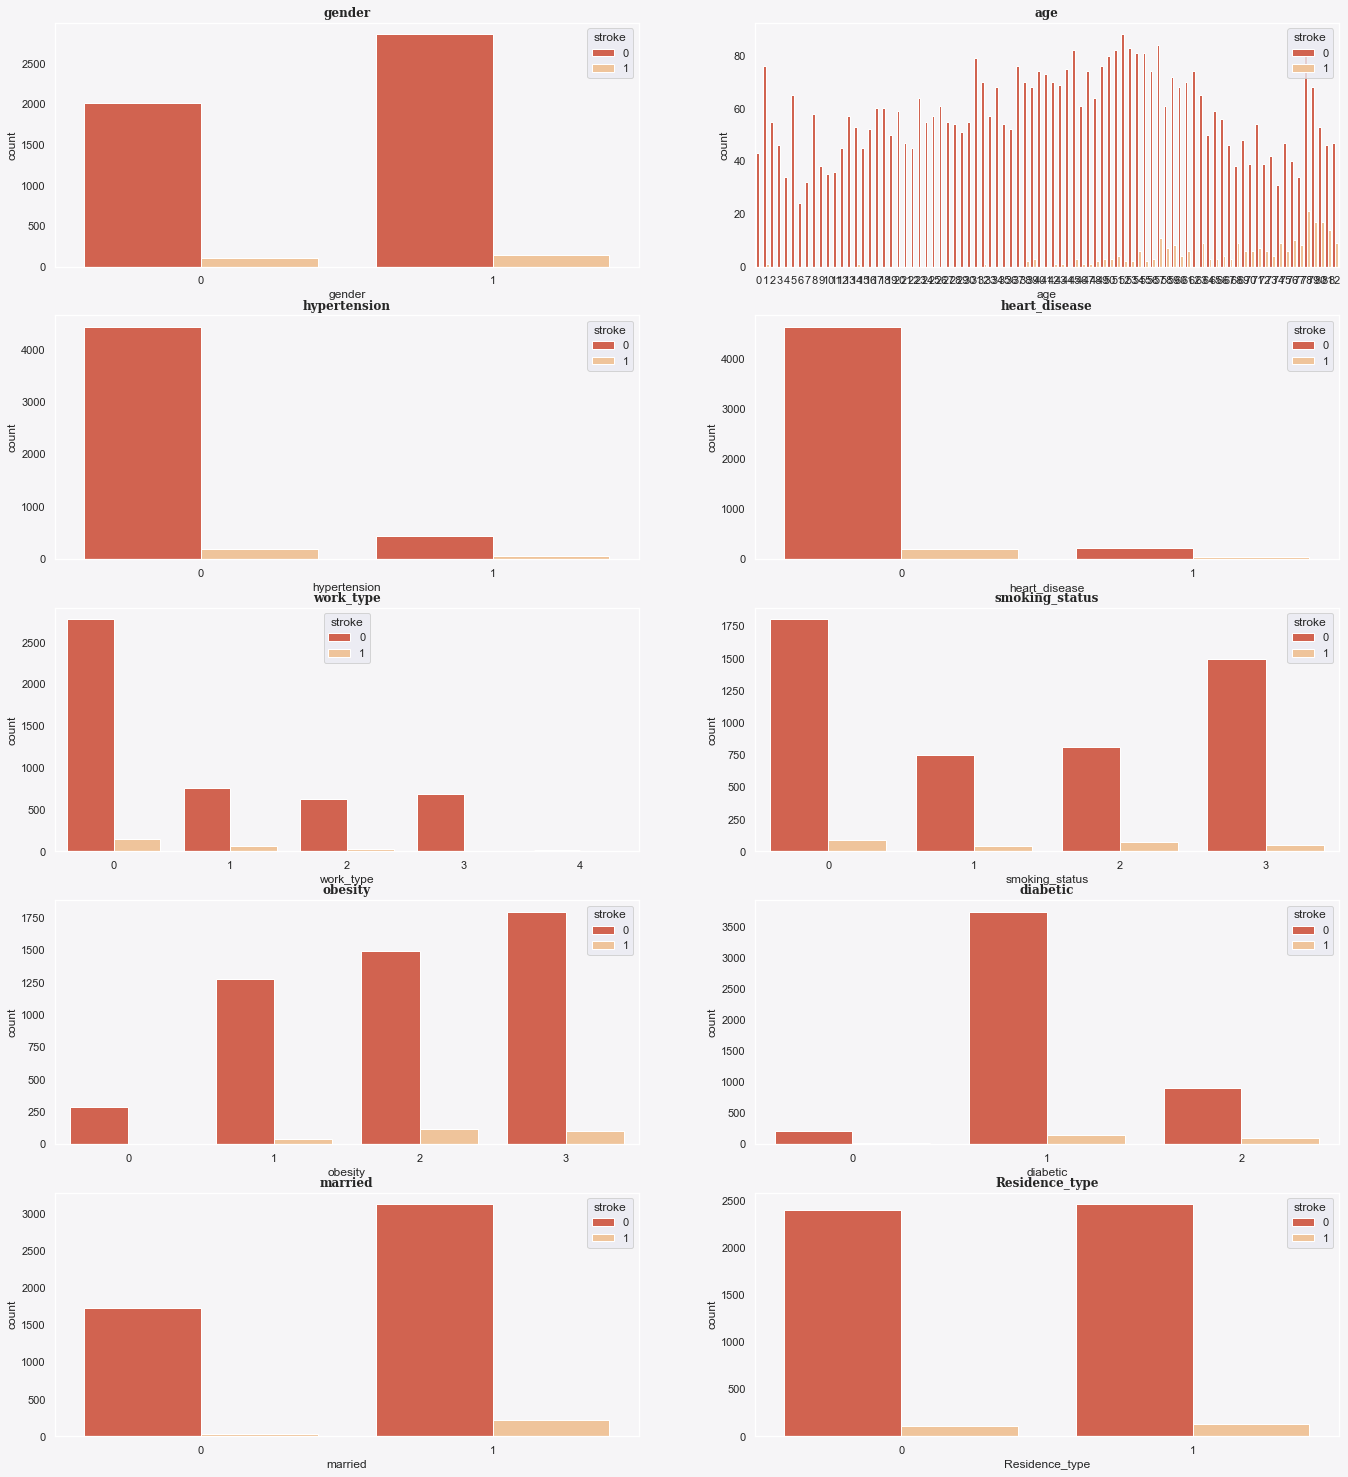

In [25]:
from plotly import __version__
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

init_notebook_mode(connected=True)
cf.go_offline()
cat_df =df[['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
            'smoking_status','obesity', 'diabetic', 'married','Residence_type']].copy()

fig=plt.figure(figsize=(23,26))
background_color = '#f6f5f7'
fig.patch.set_facecolor(background_color) 
for indx,val in enumerate(cat_df.columns):
    ax=plt.subplot(5,2,indx+1)
    ax.set_facecolor(background_color)
    ax.set_title(val,fontweight='bold',fontfamily='serif')
    for i in ['top','right']:
        ax.spines[i].set_visible(True)
    ax.grid(linestyle=':',axis='y')
    sns.countplot(cat_df[val],palette='OrRd_r',hue=df['stroke'])

In [15]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'smoking_status', 'stroke', 'obesity', 'diabetic', 'married',
       'Residence_type'],
      dtype='object')

### One Hot Encoding for Age Group Column
#### Hasn't been implemented yet. Feel free to add this in...

In [ ]:
# # example of a one hot encoding
# from numpy import asarray
# from sklearn.preprocessing import OneHotEncoder
# # define data
# data = asarray(df['age_range'])
# print(data)
# # define one hot encoding
# encoder = OneHotEncoder(sparse=False)
# # transform data
# onehot = encoder.fit_transform(data.reshape(-1, 1))
# print(onehot)

In [ ]:
df.info()

### Splitting the Data

In [26]:
from sklearn.model_selection import train_test_split
def split_data(df):
    '''
    Takes in a DataFrame and splits it into 60%/20%/20% for train,
    validate, and test DataFrames using random_rate=19
    '''

    # split data into train, validate, and test datasets
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=19)
    train, validate = train_test_split(train_validate, test_size=0.25,
                                            random_state=19)

    return train, validate, test

In [27]:
train, validate, test = split_data(df)

In [ ]:
train.shape

In [ ]:
validate.shape

In [ ]:
test.shape

In [28]:

def split_xy(train, validate, test, target):
    '''
    Takes in the three train, validate, and test DataFrames and returns
    six X, y DataFrames after splitting the target from the X data
    '''

    # split train into X, y
    X_train = train.drop(columns=target)
    y_train = pd.DataFrame(train[target])
    # split validate into X, y
    X_validate = validate.drop(columns=target)
    y_validate = pd.DataFrame(validate[target])
    # split test into X, y
    X_test = test.drop(columns=target)
    y_test = pd.DataFrame(test[target])

    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [29]:
X_train, y_train, X_validate, y_validate, X_test, y_test = split_xy(train, validate, test, target='stroke')

### Handling Imbalance data using SMOTE  
Synthetic Minority Oversampling Technique is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling

In [30]:
from imblearn.combine import SMOTETomek 


#Make variables from split data for smote processing

oversample = SMOTETomek(random_state=123)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
X_validate_smote, y_validate_smote = oversample.fit_resample(X_test, y_test)
X_test_smote, y_test_smote = oversample.fit_resample(X_test, y_test)

#### Comparing the Original Shape of the Data to Smote Shape

In [31]:
print('original train', X_train.shape, y_train.shape)
print('smote train', X_train_smote.shape, y_train_smote.shape)
print('-'*80)
print('original validate', X_validate.shape, y_validate.shape)
print('smote validate', X_validate_smote.shape, y_validate_smote.shape)
print('-'*80)
print('original test', X_test.shape, y_test.shape)
print('smote test', X_test_smote.shape, y_test_smote.shape)

original train (3065, 10) (3065, 1)
smote train (5746, 10) (5746, 1)
--------------------------------------------------------------------------------
original validate (1022, 10) (1022, 1)
smote validate (1894, 10) (1894, 1)
--------------------------------------------------------------------------------
original test (1022, 10) (1022, 1)
smote test (1894, 10) (1894, 1)


# Modeling
- LogisticRegression
- GaussianNB
- RandomForestClassifier
- KNeighborsClassifier
- DecisionTreeClassifier



## Train Smote vs  Validate 
- Depending how well it performs on train, will decide incorporation on Validate Data

In [32]:
print('original train', X_train.shape, y_train.shape)
print('smote train', X_train_smote.shape, y_train_smote.shape)
print('-'*80)
print('original validate', X_validate.shape, y_validate.shape)
print('smote validate', X_validate_smote.shape, y_validate_smote.shape)
print('-'*80)

original train (3065, 10) (3065, 1)
smote train (5746, 10) (5746, 1)
--------------------------------------------------------------------------------
original validate (1022, 10) (1022, 1)
smote validate (1894, 10) (1894, 1)
--------------------------------------------------------------------------------


In [33]:
# # Let's take a look at results using SMOTE on the train and validate sets 

model_dict = {
    'Logistic Reg': LogisticRegression(random_state=123, max_iter=550, solver='lbfgs'),
    'Naive Bayes': GaussianNB(),  
    'Random Forest Classifier': RandomForestClassifier(max_depth=5, random_state=123),
    'K Nearest Classifier': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    'Decison Tree': DecisionTreeClassifier(random_state=123)
            }
model_list = []
train_acc_list = []
val_acc_list = []
counter_list = []
prediction_list = []
metric_scores_list = []

for model, clf in model_dict.items():
    clf.fit(X_train_smote, y_train_smote)
    predictions = clf.predict(X_validate)
    acc = accuracy_score(y_validate, predictions)
    train_pred =  clf.predict(X_train_smote)
    train_acc = accuracy_score(y_train_smote, train_pred)
    counter = Counter(predictions)
    report = precision_recall_fscore_support(y_validate, predictions, average='binary')
    report_values =  ("precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f" % \
           (report[0], report[1], report[2], acc))


    print(model, 'Model')
    print(classification_report(y_validate, predictions))
    print(confusion_matrix(y_validate,predictions))
    print('--------------------------------')
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    val_acc_list.append(acc)   
    counter_list.append(counter)
    prediction_list.append(predictions)
    metric_scores_list.append(report_values)
    

results = pd.DataFrame({"model": model_list, "smote_train_accuracy": train_acc_list, "validate_acc": val_acc_list,'metric':metric_scores_list, 'counter': counter_list, 'predictions': prediction_list})

Logistic Reg Model
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       982
           1       0.17      0.17      0.17        40

    accuracy                           0.93      1022
   macro avg       0.57      0.57      0.57      1022
weighted avg       0.94      0.93      0.93      1022

[[948  34]
 [ 33   7]]
--------------------------------
Naive Bayes Model
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       982
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.92      0.96      0.94      1022

[[982   0]
 [ 40   0]]
--------------------------------
Random Forest Classifier Model
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       982
           1       0.17      0.33      0.23        40

  

In [34]:
from IPython.display import display, HTML

display(HTML(results.to_html()))

,model,smote_train_accuracy,validate_acc,metric,counter,predictions
0,Logistic Reg,0.908980,0.934442,"precision = 0.17, recall = 0.17, F1 = 0.17, accuracy = 0.93","{0: 981, 1: 41}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,Naive Bayes,0.902889,0.960861,"precision = 0.00, recall = 0.00, F1 = 0.00, accuracy = 0.96",{0: 1022},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Random Forest Classifier,0.911765,0.912916,"precision = 0.17, recall = 0.33, F1 = 0.23, accuracy = 0.91","{0: 947, 1: 75}","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,K Nearest Classifier,0.967282,0.905088,"precision = 0.06, recall = 0.10, F1 = 0.08, accuracy = 0.91","{0: 957, 1: 65}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,Decison Tree,0.996867,0.926614,"precision = 0.14, recall = 0.17, F1 = 0.16, accuracy = 0.93","{0: 973, 1: 49}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


### Takeaway:
- Decison Tree, KNC, and RFC are all perfroming better 
- Going to move forward with smote on validate 

### TRAIN SMOTE AND VALIDATE SMOTE VS TEST ACCURACY
- Looking at the performance with smote applied to train and validate against test

In [35]:
model_dict = {
    'Logistic Reg': LogisticRegression(random_state=123, max_iter=550, solver='lbfgs'),
    'Naive Bayes': GaussianNB(),  
    'Random Forest Classifier': RandomForestClassifier(max_depth=5, random_state=123),
    'K Nearest Classifier': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    'Decison Tree': DecisionTreeClassifier(random_state=123)
}


model_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []
counter_list = []
prediction_list = []
metric_scores_list = []

for model, clf in model_dict.items():
    clf.fit(X_train_smote, y_train_smote)
    
    clf.fit(X_validate_smote, y_validate_smote)
    
    predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    
    train_pred =  clf.predict(X_train_smote)
    val_pred =  clf.predict(X_validate_smote)
    
    
    train_acc = accuracy_score(y_train_smote, train_pred)
    val_acc = accuracy_score(y_validate_smote, val_pred)
    
    
    counter = Counter(predictions)
    report = precision_recall_fscore_support(y_test, predictions, average='binary')
    report_values =  ("precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f" % \
            (report[0], report[1], report[2], acc))


    print(model, 'Model')
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test,predictions))
    print('--------------------------------')
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(acc)   
    counter_list.append(counter)
    prediction_list.append(predictions)
    metric_scores_list.append(report_values)
    

results = pd.DataFrame({"model": model_list, "train_smote_accuracy": train_acc_list, "validate_smote_accuracy": val_acc_list, "test_acc": test_acc_list,'metric':metric_scores_list, 'counter': counter_list, 'predictions': prediction_list})

Logistic Reg Model
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       966
           1       0.06      0.02      0.03        56

    accuracy                           0.93      1022
   macro avg       0.50      0.50      0.50      1022
weighted avg       0.90      0.93      0.91      1022

[[951  15]
 [ 55   1]]
--------------------------------
Naive Bayes Model
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       0.00      0.00      0.00        56

    accuracy                           0.95      1022
   macro avg       0.47      0.50      0.49      1022
weighted avg       0.89      0.95      0.92      1022

[[966   0]
 [ 56   0]]
--------------------------------
Random Forest Classifier Model
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       966
           1       0.22      0.45      0.30        56

  

In [36]:
display(HTML(results.to_html()))

,model,train_smote_accuracy,validate_smote_accuracy,test_acc,metric,counter,predictions
0,Logistic Reg,0.907414,0.929250,0.931507,"precision = 0.06, recall = 0.02, F1 = 0.03, accuracy = 0.93","{0: 1006, 1: 16}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,Naive Bayes,0.903237,0.916051,0.945205,"precision = 0.00, recall = 0.00, F1 = 0.00, accuracy = 0.95",{0: 1022},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Random Forest Classifier,0.885834,0.918163,0.884540,"precision = 0.22, recall = 0.45, F1 = 0.30, accuracy = 0.88","{1: 112, 0: 910}","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...]"
3,K Nearest Classifier,0.888966,0.952482,0.943249,"precision = 0.48, recall = 0.45, F1 = 0.46, accuracy = 0.94","{0: 970, 1: 52}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...]"
4,Decison Tree,0.887226,0.998944,0.983366,"precision = 0.88, recall = 0.80, F1 = 0.84, accuracy = 0.98","{0: 971, 1: 51}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


#### Takeaway:
- Smote on the validate dataset is performing way better than the train dataset. 
- Smote on the validate dataset performs better than the test for the models RFC, KNC, and Decision Tree
- Going to move forward with SMOTE on the test date set.

## TRAIN SMOTE, VALIDATE SMOTE, TEST SMOTE

In [37]:
#Model with Smote on Test Data
model_dict = {
    'Logistic Reg': LogisticRegression(random_state=123, max_iter=550, solver='lbfgs'),
    'Naive Bayes': GaussianNB(),  
    'Random Forest Classifier': RandomForestClassifier(max_depth=5, random_state=123),
    'K Nearest Classifier': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    'Decison Tree': DecisionTreeClassifier(random_state=123)
}


model_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []
counter_list = []
prediction_list = []
metric_scores_list = []

for model, clf in model_dict.items():
    clf.fit(X_train_smote, y_train_smote)
    
    clf.fit(X_validate_smote, y_validate_smote)
    
    predictions = clf.predict(X_test_smote)
    acc = accuracy_score(y_test_smote, predictions)
    
    train_pred =  clf.predict(X_train_smote)
    val_pred =  clf.predict(X_validate_smote)
    
    
    train_acc = accuracy_score(y_train_smote, train_pred)
    val_acc = accuracy_score(y_validate_smote, val_pred)
    
    
    counter = Counter(predictions)
    report = precision_recall_fscore_support(y_test_smote, predictions, average='binary')
    report_values =  ("precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f" % \
            (report[0], report[1], report[2], acc))


    print(model, 'Model')
    print(classification_report(y_test_smote, predictions))
    print(confusion_matrix(y_test_smote,predictions))
    print('--------------------------------')
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(acc)   
    counter_list.append(counter)
    prediction_list.append(predictions)
    metric_scores_list.append(report_values)
    

results = pd.DataFrame({"model": model_list, "train_smote_accuracy": train_acc_list, "validate_smote_accuracy": val_acc_list, "test_smote_acc": test_acc_list,'metric':metric_scores_list, 'counter': counter_list, 'predictions': prediction_list})

Logistic Reg Model
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       947
           1       0.98      0.87      0.93       947

    accuracy                           0.93      1894
   macro avg       0.93      0.93      0.93      1894
weighted avg       0.93      0.93      0.93      1894

[[933  14]
 [120 827]]
--------------------------------
Naive Bayes Model
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       947
           1       1.00      0.83      0.91       947

    accuracy                           0.92      1894
   macro avg       0.93      0.92      0.92      1894
weighted avg       0.93      0.92      0.92      1894

[[947   0]
 [159 788]]
--------------------------------
Random Forest Classifier Model
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       947
           1       0.92      0.92      0.92       947

  

In [41]:
display(results) 
Counter(y_test_smote)

,model,train_smote_accuracy,validate_smote_accuracy,test_smote_acc,metric,counter,predictions
0,Logistic Reg,0.907414,0.929250,0.929250,"precision = 0.98, recall = 0.87, F1 = 0.93, ac...","{0: 1053, 1: 841}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Naive Bayes,0.903237,0.916051,0.916051,"precision = 1.00, recall = 0.83, F1 = 0.91, ac...","{0: 1106, 1: 788}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Random Forest Classifier,0.885834,0.918163,0.918163,"precision = 0.92, recall = 0.92, F1 = 0.92, ac...","{0: 946, 1: 948}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,K Nearest Classifier,0.888966,0.952482,0.952482,"precision = 0.97, recall = 0.93, F1 = 0.95, ac...","{0: 985, 1: 909}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Decison Tree,0.887226,0.998944,0.998944,"precision = 1.00, recall = 1.00, F1 = 1.00, ac...","{0: 945, 1: 949}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Counter({'stroke': 1})

In [46]:
y_test_smote.value_counts()

stroke
0         947
1         947
dtype: int64

### Takeaways:
- Smote data improved the accuracy on all sample sets.

## Testing Predicitions

- Random Forest seems to be the only one having higher values of positive predictions (1) but we need to see if these predictions are actually accurate. I suspect that the Decision Tree is overfit...

In [47]:
y_test_analys_smote = y_test_smote.reset_index().drop('index', axis=1)
index = y_test_analys_smote.index[y_test_analys_smote['stroke'] == 1]
print('predictions by RandomForest for all true values being positive:  ', Counter(prediction_list[2][index]) )
print('all predictions by RandomForest:  ', Counter(prediction_list[2]) )

predictions by RandomForest for all true values being positive:   Counter({1: 870, 0: 77})
all predictions by RandomForest:   Counter({1: 948, 0: 946})


In [53]:
print('Using RandomForest Classifier, our positive values match correctly for over ', (870/947) *100, ' % of the values.')

Using RandomForest Classifier, our positive values match correctly for over  91.86906019007391  % of the values.


### Takeways:
- Using the Random Forest Classifier, our positive values match correctly for over 91% of the values.